# Example Pipeline for e401k

This notebook is a proof-of-concept for generating causal samples from external samples

In [2]:
import contextlib
import sys
import os
sys.path.append("../")  # go to parent dir
# sys.path.append("../data/analysis/")  # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
# jnp.set_printoptions(precision=2)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
from frugal_flows.bijections import UnivariateNormalCDF
from frugal_flows.benchmarking import FrugalFlowModel
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
import torch
from benchmarking import compare_datasets


import data.template_causl_simulations as causl_py
import data.analysis.validationMethods as valMethods
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

seed = 0
N = 2000
B = 50
sampling_size = 1000
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

In [3]:
marginal_hyperparam_dict = {
    'learning_rate': 5e-4,
    # 'learning_rate': 0.2,
    'RQS_knots': 8,
    'flow_layers': 3,
    'nn_depth': 5,    
    'nn_width': 10,
    'max_patience': 100,
    'max_epochs': 20000
}
hyperparam_dict = {
    'learning_rate': 0.00261635,
    'RQS_knots': 5,
    'flow_layers': 2,
    'nn_depth': 3,    
    'nn_width': 34,
    'max_patience': 100,
    'max_epochs': 20000
}
causal_margin_hyperparams_dict = {
    'RQS_knots': 4,
    'flow_layers': 8,
    'nn_depth': 10,    
    'nn_width': 50,
}
seed=7

# Load data
e401k = pd.read_csv('../data/filtered_401k_data.csv')

# Preprocess data
outcome_col = 'net_tfa'
treatment_col = 'e401'
standardised_outcome_col = f'{outcome_col}_standardised'
Y_control = e401k.loc[e401k[treatment_col]==0, outcome_col]
Y_control_mean = Y_control.mean()
Y_control_std = Y_control.std()
e401k[standardised_outcome_col] = (e401k[outcome_col] - Y_control_mean) / Y_control_std
e401k_filtered = e401k.loc[(e401k[standardised_outcome_col] > -2) & (e401k[standardised_outcome_col] < +3)]
X = jnp.array(e401k_filtered[treatment_col].values)[:, None]
Y = jnp.array(e401k_filtered[standardised_outcome_col].values)[:, None]
covariate_colnames = [col for col in e401k_filtered.columns if col not in [outcome_col,standardised_outcome_col, treatment_col]]
# ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown', 'p401']

cont_columns = ['age', 'inc']
disc_columns = ['educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown', 'p401']

for col in cont_columns:
    mean = e401k_filtered[col].mean()
    std = e401k_filtered[col].std()
    e401k_filtered[col] = (e401k_filtered[col] - mean) / std

Z_cont = jnp.array(e401k_filtered[cont_columns].values).astype(float)
Z_disc = jnp.array(e401k_filtered[disc_columns].values)
Z_disc = jnp.array(e401k_filtered[covariate_colnames].values)
e401k_rescaled = e401k[
    [standardised_outcome_col, treatment_col] + covariate_colnames
]

true_ATE = 1000
benchmark_flow = FrugalFlowModel(Y=Y, X=X, Z_disc=Z_disc, Z_cont=Z_cont, confounding_copula=None)
benchmark_flow.train_benchmark_model(
    training_seed=jr.PRNGKey(seed),
    marginal_hyperparam_dict=marginal_hyperparam_dict,
    frugal_hyperparam_dict=hyperparam_dict,
    causal_model='location_translation',
    causal_model_args={'ate': 0, **causal_margin_hyperparams_dict},
    prop_flow_hyperparam_dict=causal_margin_hyperparams_dict
)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 11%| | 2268/20000 [08:01<1:02:42,  4.71it/s, train=0.3491949176877551, val=0.31670796225320397 (Max pat
  1%| | 273/20000 [00:45<55:03,  5.97it/s, train=1.251021540722565, val=1.2267386026922316 (Max patience
  5%| | 1098/20000 [21:06<6:03:15,  1.15s/it, train=-10.352943730419895, val=-9.587169296235443 (Max pat
 15%|▏| 15/100 [00:13<01:18,  1.08it/s, train=-0.3533417104487895, val=-0.37471308556617866 (Max patienc


In [21]:
covariate_colnames

['age',
 'inc',
 'educ',
 'fsize',
 'marr',
 'twoearn',
 'db',
 'pira',
 'hown',
 'p401']

In [22]:
def rescale_outcome(x, mean, std):
    return x * std + mean

### Unconfounded Data

In [23]:
sim_data_df = benchmark_flow.generate_samples(
    key=jr.PRNGKey(10*seed),
    sampling_size=1000,
    copula_param=0.,
    outcome_causal_model='location_translation',
    outcome_causal_args={'ate': true_ATE / Y_control_std},
    with_confounding=True
)
sim_data_df.columns = e401k_rescaled.columns

(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.


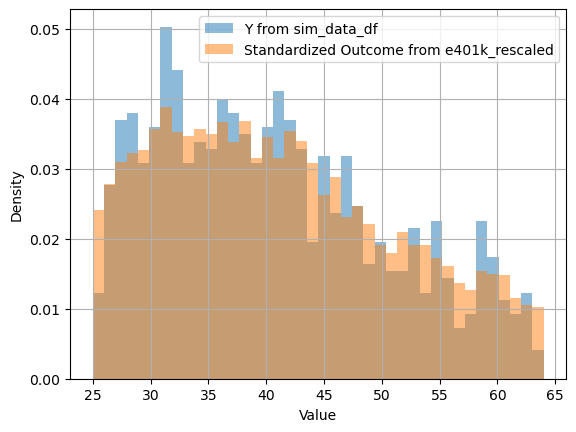

In [5]:
plotted_col = 'age'#standardised_outcome_col
sim_data_df[plotted_col].hist(density=True, alpha=0.5, label='Y from sim_data_df', bins=40)
e401k_rescaled[plotted_col].hist(density=True, alpha=0.5, label='Standardized Outcome from e401k_rescaled', bins=40)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

Text(0.5, 1.0, 'Generated e401k Data')

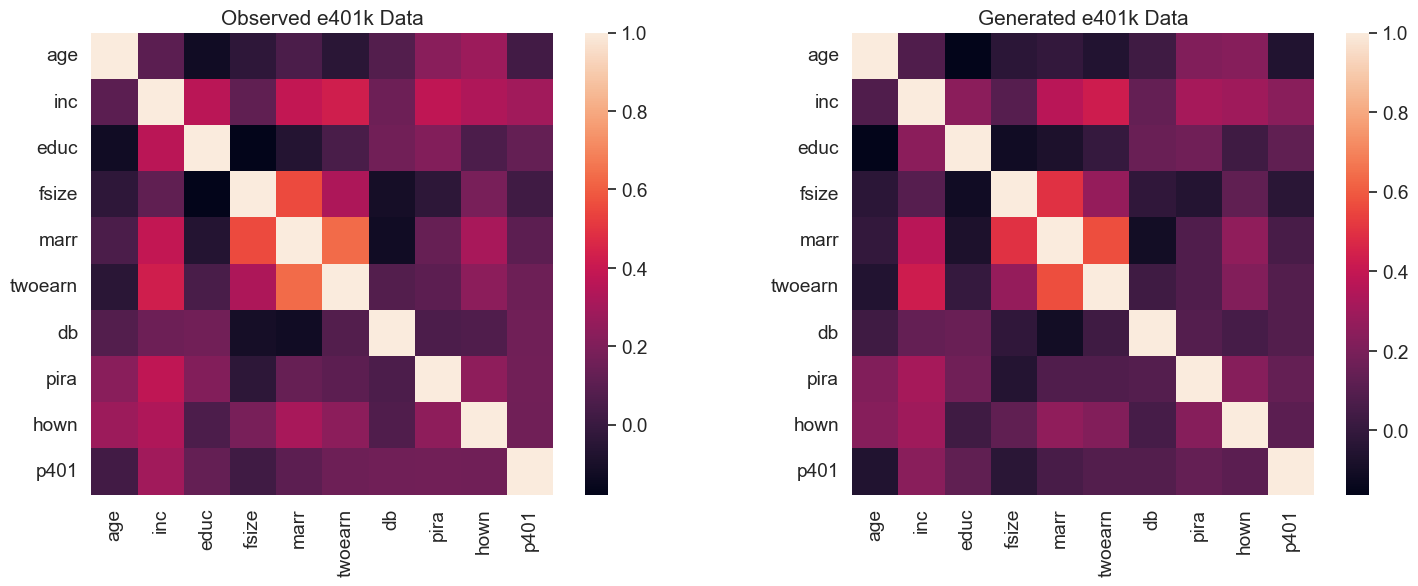

In [25]:
import seaborn as sns

sns.set(font_scale=1.25)
fig,ax = plt.subplots(ncols=2,figsize=(18,6))
sns.heatmap(e401k_rescaled[covariate_colnames].corr(),ax=ax[0],square=True)
ax[0].set_title('Observed e401k Data')
sns.heatmap(sim_data_df[covariate_colnames].corr(),ax=ax[1],square=True)
ax[1].set_title('Generated e401k Data')
# fig.savefig('Lalonde_NSW_0_1000_0.png')

In [26]:
import torch
from torch_two_sample import MMDStatistic, EnergyStatistic, FRStatistic, KNNStatistic

n_real = e401k_rescaled.shape[0]
n_synth = sim_data_df.shape[0]

# Convert to torch tensors
real_samples_var = torch.tensor(e401k_rescaled.values, dtype=torch.float32)
synth_samples_var = torch.tensor(sim_data_df.values, dtype=torch.float32)

# Initialize test statistics
alphas = [0.1]
mmd = MMDStatistic(n_real, n_synth)
mmd_matrix = mmd(real_samples_var, synth_samples_var, alphas, ret_matrix=True)[1]
print(mmd.pval(mmd_matrix, n_permutations=1000))

0.9860000014305115


In [ ]:
alphas = [0.5, 1.0, 2.0]
k = 3
# cols = ['age', 'black', 'education']
cols = ["age"]#, "education", "black", "hispanic", "married", "nodegree"]
# cols = covariate_colnames
compare_datasets(e401k_rescaled.loc[:, cols].values, sim_data_df.loc[:, cols].values, alphas=alphas, k=3, n_permutations=1000)

Calculating Metrics...
MMD Calculated in 0.8284 seconds...


### Confounded Data

In [ ]:
confounded_results_list = []
for seed in range(B):
    print(f"Run {seed+1} / {B}")
    sim_data_df = benchmark_flow.generate_samples(
        key=jr.PRNGKey(10*seed),
        sampling_size=sampling_size,
        copula_param=0.,
        outcome_causal_model='location_translation',
        outcome_causal_args={'ate': true_ATE / Y_control_std},
        with_confounding=True
    )
    sim_data_df['Y'] = sim_data_df['Y'].apply(lambda x: rescale_outcome(x, Y_control_mean, Y_control_std))    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        model_fits = valMethods.run_model_fits('Y', 'X', sim_data_df, sample_frac=1, repeats=1, replace=True)
    ate_reslts = pd.concat([
        model_fits['nonbootstrap_results'][['method', 'ate']], 
        model_fits['bootstrap_results'][['method', 'ate']]
    ])
    confounded_results_list.append(ate_reslts)
confounded_model_fit_results = pd.concat(confounded_results_list)
confounded_model_fit_results = confounded_model_fit_results.loc[
    ~confounded_model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
confounded_model_fit_results['ate'] = confounded_model_fit_results['ate'].apply(clean_ate)

### Hidden Confounded Data

In [ ]:
rho = 0.2
hidden_confounded_results_list = []
for seed in range(B):
    print(f"Run {seed+1} / {B}")
    sim_data_df = benchmark_flow.generate_samples(
        key=jr.PRNGKey(10*seed),
        sampling_size=sampling_size,
        copula_param=rho,
        outcome_causal_model='location_translation',
        outcome_causal_args={'ate': true_ATE / Y_control_std},
        with_confounding=True
    )
    sim_data_df['Y'] = sim_data_df['Y'].apply(lambda x: rescale_outcome(x, Y_control_mean, Y_control_std))    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        model_fits = valMethods.run_model_fits('Y', 'X', sim_data_df, sample_frac=1, repeats=1, replace=True)
    ate_reslts = pd.concat([
        model_fits['nonbootstrap_results'][['method', 'ate']], 
        model_fits['bootstrap_results'][['method', 'ate']]
    ])
    hidden_confounded_results_list.append(ate_reslts)
hidden_confounded_model_fit_results = pd.concat(hidden_confounded_results_list)
hidden_confounded_model_fit_results = hidden_confounded_model_fit_results.loc[
    ~hidden_confounded_model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
hidden_confounded_model_fit_results['ate'] = hidden_confounded_model_fit_results['ate'].apply(clean_ate)

## Some demo plots

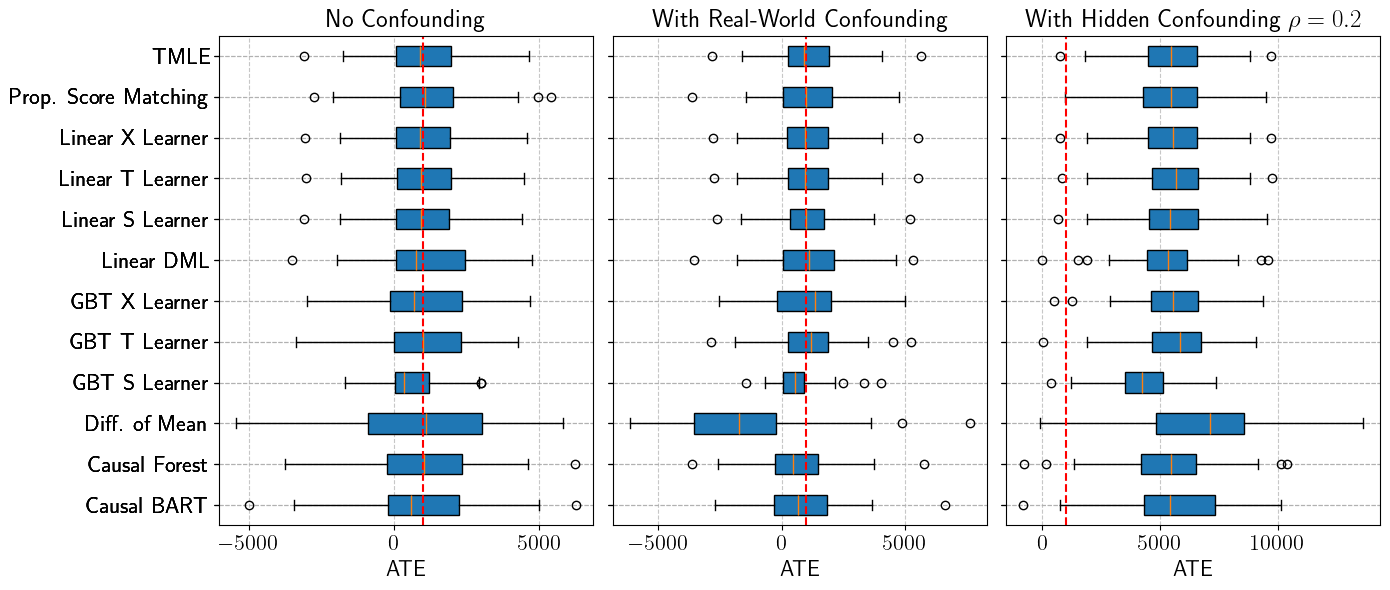

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

# Apply the cleaning function to the data
df1 = non_confounded_model_fit_results.copy()
df2 = confounded_model_fit_results.copy()
df3 = hidden_confounded_model_fit_results.copy()

# Group data by method
grouped_df1 = df1.groupby('method')['ate'].apply(list).reset_index()
grouped_df2 = df2.groupby('method')['ate'].apply(list).reset_index()
grouped_df3 = df3.groupby('method')['ate'].apply(list).reset_index()

# Plot the box and whisker diagrams side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharey=True)

# Define a common font size
font_size = 16
title_fontsize = font_size + 2

# Create the boxplot for the first dataset
axes[0].boxplot(grouped_df1['ate'], vert=False, patch_artist=True, labels=grouped_df1['method'])
axes[0].axvline(x=true_ATE, color='red', linestyle='--')
axes[0].set_xlabel('ATE', fontsize=font_size)
axes[0].set_title('No Confounding', fontsize=title_fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=font_size)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[1].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[1].axvline(x=true_ATE, color='red', linestyle='--')
axes[1].set_xlabel('ATE', fontsize=font_size)
axes[1].set_title(r'With Real-World Confounding', fontsize=title_fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=font_size)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the third dataset
axes[2].boxplot(grouped_df3['ate'], vert=False, patch_artist=True, labels=grouped_df3['method'])
axes[2].axvline(x=true_ATE, color='red', linestyle='--')
axes[2].set_xlabel('ATE', fontsize=font_size)
axes[2].set_title(r'With Hidden Confounding $\rho=0.2$', fontsize=title_fontsize)
axes[2].tick_params(axis='both', which='major', labelsize=font_size)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('e401k_box_and_whisker_plots.pdf', format='pdf')

# Display the plot
plt.show()